# Machine Learning vs Deep Learning 

## Data Collection and Preprocessing
Dataset : MINST

### Imports

In [2]:
import torch as th
import torch.nn as nn

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

import tqdm

### Downloading & Labeling Data using PyTorch

In [3]:
train_data = datasets.MNIST (
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = datasets.MNIST (
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)



#### Showing Sample of data

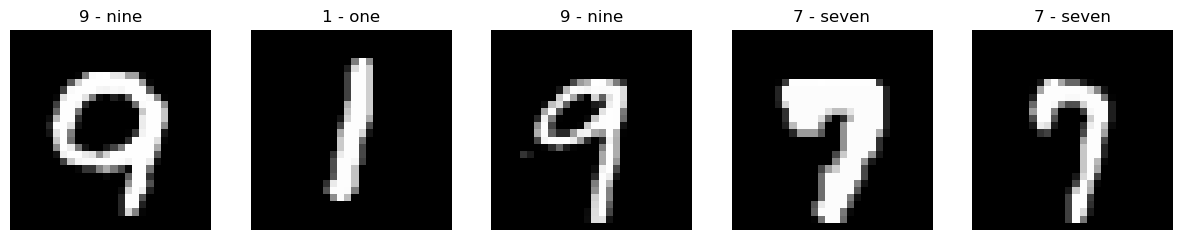

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    idx = np.random.randint(0, len(train_data))
    image, label = train_data[idx]
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(train_data.classes[label])
    axes[i].axis(False)

## Feature Extraction with SIFT and Bag-of-Words

Methodology:
1. Function to convert PyTorch tensor images to 8-bit numpy arrays
2. Convert dataset images to numpy arrays in the correct format
3. SIFT feature extractor
4. Function to extract SIFT features from images
5. Extract SIFT features from the training images
6. Function to create histograms of visual words

In [5]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import torch
from torchvision import datasets, transforms



def tensor_to_cv2(tensor_img):
    img = tensor_img.numpy().squeeze() * 255  # Convert to numpy and scale to [0, 255]
    img = img.astype(np.uint8)  # Convert to uint8
    return img


train_images = [tensor_to_cv2(image) for image, label in train_data]
test_images = [tensor_to_cv2(image) for image, label in test_data]

sift = cv2.SIFT_create()


def extract_sift_features(images):
    descriptors = []
    for img in tqdm.tqdm(images):
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            descriptors.append(des)
    return descriptors


train_descriptors = extract_sift_features(train_images)
test_descriptors = extract_sift_features(test_images)

# Clustering using MiniBatchKMeans for better performance
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=1000, random_state=42)
kmeans.fit(np.vstack(train_descriptors))


def create_histograms(descriptors, kmeans):
    histograms = []
    for des in descriptors:
        hist = np.zeros(len(kmeans.cluster_centers_))
        if des is not None:
            clusters = kmeans.predict(des)
            for c in clusters:
                hist[c] += 1
        histograms.append(hist)
    return histograms


train_histograms = create_histograms(train_descriptors, kmeans)
test_histograms = create_histograms(test_descriptors, kmeans)
scaler = StandardScaler().fit(train_histograms)
train_histograms = scaler.transform(train_histograms)
test_histograms = scaler.transform(test_histograms)

# 

100%|██████████| 10000/10000 [00:02<00:00, 3407.36it/s]
/Users/yahiaehab/University/Projects/ImgProcessing/Project/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


### Machine Learning with Bag-of-Words Representation

Methodology:
1. Extract valid labels corresponding to images with SIFT descriptors
2. Apply PCA for dimensionality reduction
3. Train the Support Vector Classifier

In [6]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

valid_labels = [
    label
    for (image, label), des in zip(train_data, train_descriptors)
    if des is not None
]
valid_labels_test = [
    label for (image, label), des in zip(test_data, test_descriptors) if des is not None
]

# Ensure the histograms and labels have the same length
assert len(train_histograms) == len(
    valid_labels
), "Mismatch between histograms and labels"
assert len(test_histograms) == len(
    valid_labels_test
), "Mismatch between histograms and labels"

pca = PCA(n_components=100)  # Reduce to 100 dimensions, you can adjust this number
train_histograms_pca = pca.fit_transform(train_histograms)
test_histograms_pca = pca.transform(test_histograms)

X_train, X_val, y_train, y_val = train_test_split(
    train_histograms_pca, valid_labels, test_size=0.2, random_state=42
)

svc = SVC(kernel="poly", C=10, gamma=0.01, random_state=42, verbose=True)
svc.fit(X_train, y_train)

[LibSVM]..........................*..........*.*
optimization finished, #iter = 37100
obj = -21263.789190, rho = 0.229054
nSV = 8255, nBSV = 1862
...........................*........*
optimization finished, #iter = 35765
obj = -20087.464988, rho = 0.052028
nSV = 7808, nBSV = 1783
...........................*..........*.*
optimization finished, #iter = 38114
obj = -19992.957735, rho = -0.043605
nSV = 7890, nBSV = 1722
.........................*........*
optimization finished, #iter = 33718
obj = -19801.238330, rho = -0.166949
nSV = 7742, nBSV = 1725
........................*.........*
optimization finished, #iter = 33299
obj = -18906.337332, rho = -0.323486
nSV = 7479, nBSV = 1646
.........................*.........*
optimization finished, #iter = 34857
obj = -20389.934489, rho = -0.005416
nSV = 7803, nBSV = 1795
..........................*...........*....*
optimization finished, #iter = 40608
obj = -20449.482500, rho = 0.084487
nSV = 8054, nBSV = 1787
..........................*.......

SVC(C=10, gamma=0.01, kernel='poly', random_state=42, verbose=True)

#### Validation & Visualization

In [7]:
y_pred_val = svc.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)}")
print("Validation Classification Report:\n", classification_report(y_val, y_pred_val))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

y_pred_test = svc.predict(test_histograms_pca)
print(f"Test Accuracy: {accuracy_score(valid_labels_test, y_pred_test)}")
print(
    "Test Classification Report:\n",
    classification_report(valid_labels_test, y_pred_test),
)
print("Test Confusion Matrix:\n", confusion_matrix(valid_labels_test, y_pred_test))

Validation Accuracy: 0.10515991471215352
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.11      0.11      1203
           1       0.11      0.22      0.15      1292
           2       0.09      0.09      0.09      1168
           3       0.12      0.10      0.11      1200
           4       0.10      0.09      0.10      1150
           5       0.11      0.08      0.09      1082
           6       0.11      0.09      0.10      1126
           7       0.10      0.10      0.10      1194
           8       0.09      0.07      0.08      1157
           9       0.09      0.07      0.08      1153

    accuracy                           0.11     11725
   macro avg       0.10      0.10      0.10     11725
weighted avg       0.10      0.11      0.10     11725

Validation Confusion Matrix:
 [[138 264 113 105 105  68  92 135  87  96]
 [135 283 143 116 103  92  82 139 100  99]
 [130 240 110  96 104  85  94 124  99  86]
 [121 

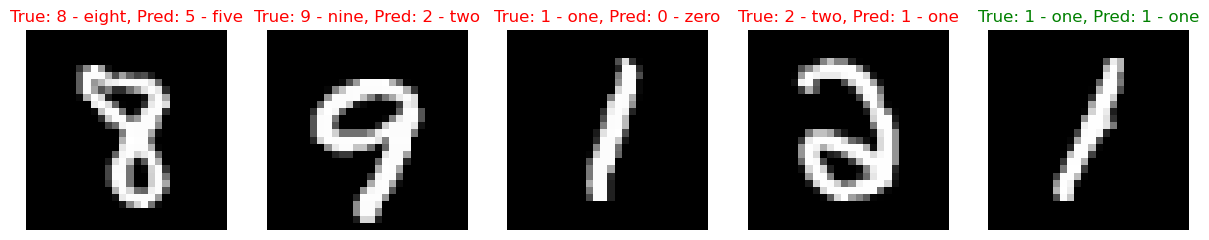

In [8]:
import matplotlib.pyplot as plt
import numpy as np


## Plot the predicted vs actual with green color for correct predictions and red color for incorrect predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    idx = np.random.randint(0, len(test_data))
    image, label = test_data[idx]
    pred = y_pred_test[idx]
    color = "green" if label == pred else "red"
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"True: {test_data.classes[label]}, Pred: {train_data.classes[pred]}", color=color)
    axes[i].axis(False)

plt.show()

## Deep Learning with CNN

1. Define the CNN model
2. Compile the model
3. Prepare the data for training

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns

model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

X_train_cnn = np.array(
    [image.numpy().reshape(28, 28, 1) for image, label in train_data]
)
y_train_cnn = np.array([label for image, label in train_data])
X_test_cnn = np.array([image.numpy().reshape(28, 28, 1) for image, label in test_data])
y_test_cnn = np.array([label for image, label in test_data])

history = model.fit(X_train_cnn, y_train_cnn, epochs=5, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cnn, verbose=2)
print(f"Test accuracy: {test_acc}")



Epoch 1/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1639 - accuracy: 0.9507 - val_loss: 0.0694 - val_accuracy: 0.9791
Epoch 2/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0509 - accuracy: 0.9840 - val_loss: 0.0448 - val_accuracy: 0.9862
Epoch 3/5
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0364 - accuracy: 0.9887 - val_loss: 0.0431 - val_accuracy: 0.9874
Epoch 4/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0433 - val_accuracy: 0.9883
Epoch 5/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0408 - val_accuracy: 0.9874
313/313 - 1s - loss: 0.0327 - accuracy: 0.9900 - 757ms/epoch - 2ms/step
Test accuracy: 0.9900000095367432


### Classification & Visualization

313/313 [==============================] - 1s 2ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



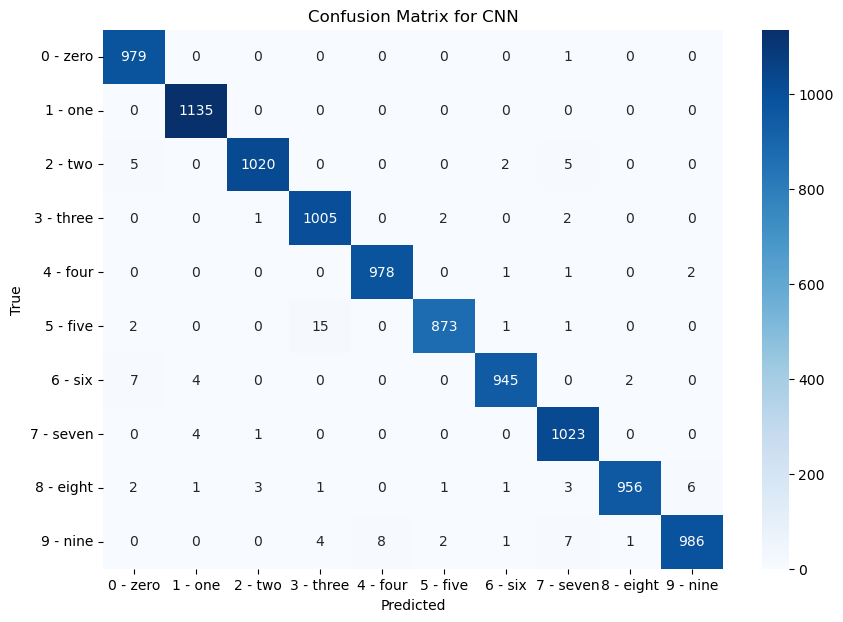

In [10]:
y_pred_cnn = np.argmax(model.predict(X_test_cnn), axis=-1)
print("CNN Classification Report:\n", classification_report(y_test_cnn, y_pred_cnn))

conf_matrix = confusion_matrix(y_test_cnn, y_pred_cnn)

plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_data.classes,
    yticklabels=train_data.classes,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for CNN")
plt.show()

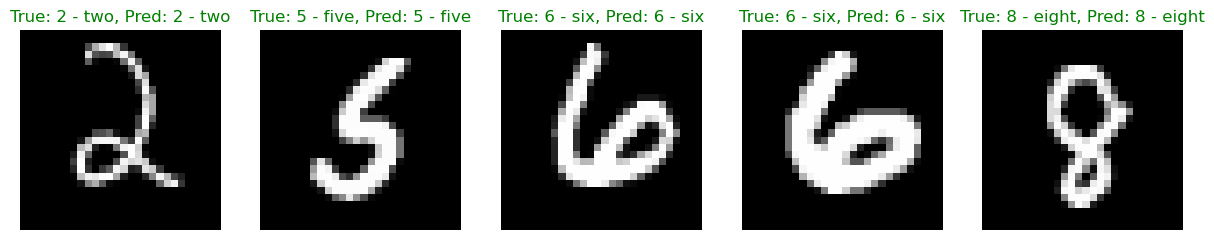

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    idx = np.random.randint(0, len(test_data))
    image, label = test_data[idx]
    pred = y_pred_cnn[idx]
    color = "green" if label == pred else "red"
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"True: {test_data.classes[label]}, Pred: {train_data.classes[pred]}", color=color)
    axes[i].axis(False)

plt.show()